In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [2]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


torch.Size([1, 3, 224, 224])
label=388


In [4]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    # 梯度清零
    optimizer.zero_grad()

    # forward + backward
    output = model(img)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    
    print("epoch={} loss={} label={}".format(epoch,loss,label))
    
    #如果定向攻击成功
    if label == target:
        break  
    loss.backward()
    optimizer.step()


epoch=0 loss=12.659993171691895 label=388
epoch=1 loss=11.617826461791992 label=388
epoch=2 loss=10.711487770080566 label=388
epoch=3 loss=9.929147720336914 label=388
epoch=4 loss=9.27491569519043 label=388
epoch=5 loss=8.724626541137695 label=388
epoch=6 loss=8.258687973022461 label=388
epoch=7 loss=7.857187271118164 label=388
epoch=8 loss=7.49109411239624 label=388
epoch=9 loss=7.165097236633301 label=388
epoch=10 loss=6.861171245574951 label=388
epoch=11 loss=6.5662078857421875 label=388
epoch=12 loss=6.272679805755615 label=388
epoch=13 loss=5.979458808898926 label=388
epoch=14 loss=5.6953582763671875 label=388
epoch=15 loss=5.3950514793396 label=388
epoch=16 loss=5.086915493011475 label=388
epoch=17 loss=4.783505916595459 label=388
epoch=18 loss=4.469130992889404 label=388
epoch=19 loss=4.1630167961120605 label=388
epoch=20 loss=3.8569746017456055 label=388
epoch=21 loss=3.5583629608154297 label=388
epoch=22 loss=3.264517307281494 label=388
epoch=23 loss=2.973933696746826 label=29

(3, 224, 224)


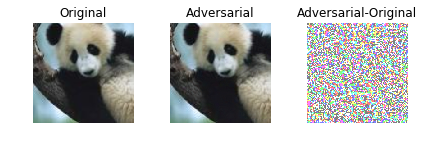

In [8]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
#adv = adv[..., ::-1]  # RGB to BGR
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,388,adv,target.data.cpu().numpy()[0])